# Machine Learning For Market Trading

In [67]:
import pandas as pd
df = pd.read_csv("EURUSD.csv")

#Check if NA values are in data
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.tail()

,Gmt time,open,high,low,close,volume
28821,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63
28822,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66
28823,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33
28824,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53
28825,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05


# Support and Resistance FUNCTIONS

In [68]:
def support(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.low[i]>df1.low[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.low[i]<df1.low[i-1]):
            return 0
    return 1

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.high[i]<df1.high[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.high[i]>df1.high[i-1]):
            return 0
    return 1

In [69]:
length = len(df)
high = list(df['high'])
low = list(df['low'])
close = list(df['close'])
open = list(df['open'])
bodydiff = [0] * length

highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(l):
    row=l
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001      

    bodydiffmin = 0.002
    if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]<close[row-1] and
        open[row]>close[row] and 
        (open[row]-close[row-1])>=-0e-5 and close[row]<open[row-1]): #+0e-5 -5e-5
        return 1

    elif(bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]>close[row-1] and
        open[row]<close[row] and 
        (open[row]-close[row-1])<=+0e-5 and close[row]>open[row-1]):#-0e-5 +5e-5
        return 2
    else:
        return 0
       
def isStar(l):
    bodydiffmin = 0.0020
    row=l
    highdiff[row] = high[row]-max(open[row],close[row])
    lowdiff[row] = min(open[row],close[row])-low[row]
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001
    ratio1[row] = highdiff[row]/bodydiff[row]
    ratio2[row] = lowdiff[row]/bodydiff[row]

    if (ratio1[row]>1 and lowdiff[row]<0.2*highdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]>close[row]):
        return 1
    elif (ratio2[row]>1 and highdiff[row]<0.2*lowdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]<close[row]):
        return 2
    else:
        return 0
    
def closeResistance(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.high[l]-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c2 = abs(max(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c3 = min(df.open[l],df.close[l])<min(levels, key=lambda x:abs(x-df.high[l]))
    c4 = df.low[l]<min(levels, key=lambda x:abs(x-df.high[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0
    
def closeSupport(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.low[l]-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c2 = abs(min(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c3 = max(df.open[l],df.close[l])>min(levels, key=lambda x:abs(x-df.low[l]))
    c4 = df.high[l]>min(levels, key=lambda x:abs(x-df.low[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

In [70]:
n1=2
n2=2
backCandles=30
signal = [0] * length

for row in range(backCandles, len(df)-n2):
    ss = []
    rr = []
    for subrow in range(row-backCandles+n1, row+1):
        if support(df, subrow, n1, n2):
            ss.append(df.low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.high[subrow])
    #!!!! parameters
    if ((isEngulfing(row)==1 or isStar(row)==1) and closeResistance(row, rr, 150e-5) ):#and df.RSI[row]<30
        signal[row] = 1
    elif((isEngulfing(row)==2 or isStar(row)==2) and closeSupport(row, ss, 150e-5)):#and df.RSI[row]>70
        signal[row] = 2
    else:
        signal[row] = 0



In [71]:
df['signal']=signal

In [72]:
df[df['signal']==1].count()

Gmt time    258
open        258
high        258
low         258
close       258
volume      258
signal      258
dtype: int64

In [74]:
df.columns = ['Local time', 'Open', 'High', 'Low', 'Close', 'Volume', 'signal']
#df=df.iloc[100:200]
df

,Local time,Open,High,Low,Close,Volume,signal
0,04.05.2003 21:00:00.000,1.12354,1.12354,1.12166,1.12274,95533.0976,0
1,05.05.2003 01:00:00.000,1.12242,1.12276,1.12067,1.12126,93778.5996,0
2,05.05.2003 05:00:00.000,1.12139,1.12255,1.12030,1.12113,90924.6992,0
3,05.05.2003 09:00:00.000,1.12092,1.12331,1.12049,1.12174,91254.6992,0
4,05.05.2003 13:00:00.000,1.12194,1.12900,1.12130,1.12712,308003.4083,0
...,...,...,...,...,...,...,...
28821,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.6300,0
28822,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.6600,0
28823,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.3300,0
28824,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.5300,0


In [76]:
#Target flexible way
pipdiff = 250*1e-4 #for TP
SLTPRatio = 0.5 #pipdiff/Ratio gives SL
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
      
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

<Axes: >

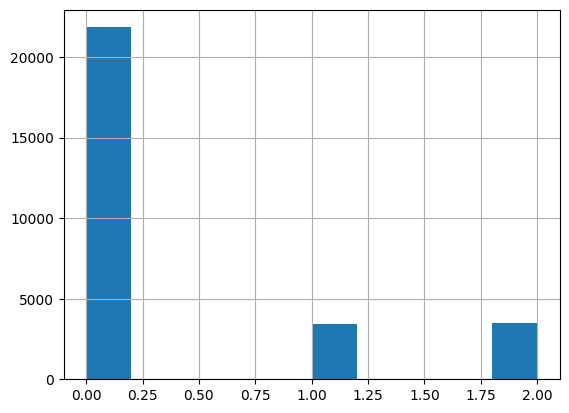

In [77]:
#!!! pitfall one category high frequency
df['Target'] = mytarget(30, df)
#df.tail(20)
#df['Target'] = df['Target'].astype(int)
df['Target'].hist()

In [78]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
print(df.describe())

               Open          High           Low         Close         Volume  \
count  28794.000000  28794.000000  28794.000000  28794.000000   28794.000000   
mean       1.254497      1.256548      1.252428      1.254505   83257.049149   
std        0.119545      0.119880      0.119171      0.119544  100682.989811   
min        1.036930      1.039200      1.034050      1.036970       0.380000   
25%        1.153813      1.155663      1.151880      1.153872   20411.445125   
50%        1.242320      1.244490      1.239965      1.242380   47929.085450   
75%        1.338808      1.340830      1.336597      1.338820  102535.001000   
max        1.599500      1.604030      1.596950      1.599240  752269.093800   

             signal        Target  
count  28794.000000  28794.000000  
mean       0.027367      0.363062  
std        0.212193      0.689099  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.

In [84]:
import numpy as np
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# ATR Calculation
def calculate_atr(df, length=20):
    df['high_low'] = df['High'] - df['Low']
    df['high_close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['low_close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
    df['atr'] = df['tr'].rolling(window=length).mean()
    return df

# RSI Calculation
def calculate_rsi(df, length=14):
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=length).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=length).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    return df

# Moving Average Calculation
def calculate_moving_averages(df, lengths=[40, 80, 160]):
    for length in lengths:
        df[f'MA{length}'] = df['Close'].rolling(window=length).mean()
    return df

# Slope Calculation
def calculate_slope(series, length=5):
    slope = np.gradient(series)
    return pd.Series(slope, name=f'{series.name}_slope')

# Apply these calculations
df = calculate_atr(df)
df = calculate_rsi(df)
df = calculate_moving_averages(df, lengths=[40, 80, 160])

# Add slopes for MA40, MA80, MA160, and RSI
df['slope_MA40'] = calculate_slope(df['MA40'])
df['slope_MA80'] = calculate_slope(df['MA80'])
df['slope_MA160'] = calculate_slope(df['MA160'])
df['slope_RSI'] = calculate_slope(df['rsi'])

# Clean up temporary columns used for calculations
df.drop(columns=['high_low', 'high_close', 'low_close', 'tr'], inplace=True)




#...................................................................................................................................................................................

# Assuming the necessary data cleaning and feature engineering has been done

# Ensure the 'signal' column exists and is categorical
df['signal'] = pd.Categorical(df['signal'])

# Use pd.get_dummies to create one-hot encoded variables for 'signal'
df_dummies = pd.get_dummies(df['signal'], prefix='signalcategory')

# Now concatenate these dummies with the original dataframe
df_model = pd.concat([df, df_dummies], axis=1)

# Drop the original 'signal' column as it is now one-hot encoded
df_model = df_model.drop(['signal'], axis=1)

# Define the attributes including the newly added ones and the one-hot encoded 'signal' categories
attributes = ['signalcategory_1', 'signalcategory_2', 'atr', 'rsi', 'MA40', 'MA80', 'MA160',
              'slope_MA40', 'slope_MA80', 'slope_MA160', 'slope_RSI']





In [85]:
df.tail()

,Local time,Open,High,Low,Close,Volume,signal,Target,atr,rsi,MA40,MA80,MA160,slope_MA40,slope_MA80,slope_MA160,slope_RSI
28789,07.10.2021 17:00:00.000,1.15558,1.15648,1.15495,1.15532,7242.850,0,0.0,0.001885,25.672878,1.159018,1.165241,1.173674,-0.000299,-0.000204,-0.000157,-0.727910
28790,07.10.2021 21:00:00.000,1.15535,1.15603,1.15528,1.15585,5008.065,0,0.0,0.001801,25.826446,1.158755,1.165036,1.173515,-0.000254,-0.000215,-0.000170,-0.410992
28791,08.10.2021 01:00:00.000,1.15585,1.15591,1.15474,1.15484,4504.430,0,0.0,0.001800,24.850895,1.158511,1.164812,1.173334,-0.000182,-0.000220,-0.000182,2.116539
28792,08.10.2021 05:00:00.000,1.15484,1.15566,1.15416,1.15537,11979.050,0,0.0,0.001796,30.059524,1.158391,1.164597,1.173150,-0.000094,-0.000208,-0.000176,9.409415
28793,08.10.2021 09:00:00.000,1.15538,1.15862,1.15534,1.15710,21107.650,0,0.0,0.001865,43.669725,1.158322,1.164395,1.172981,-0.000069,-0.000201,-0.000168,13.610201


In [62]:
print(X)

           MA40      MA80     MA160  slope_MA40  slope_MA80  slope_MA160  \
0           NaN       NaN       NaN         NaN         NaN          NaN   
1           NaN       NaN       NaN         NaN         NaN          NaN   
2           NaN       NaN       NaN         NaN         NaN          NaN   
3           NaN       NaN       NaN         NaN         NaN          NaN   
4           NaN       NaN       NaN         NaN         NaN          NaN   
...         ...       ...       ...         ...         ...          ...   
28789  1.159018  1.165241  1.173674   -0.000299   -0.000204    -0.000157   
28790  1.158755  1.165036  1.173515   -0.000254   -0.000215    -0.000170   
28791  1.158511  1.164812  1.173334   -0.000182   -0.000220    -0.000182   
28792  1.158391  1.164597  1.173150   -0.000094   -0.000208    -0.000176   
28793  1.158322  1.164395  1.172981   -0.000069   -0.000201    -0.000168   

       slope_RSI  
0            NaN  
1            NaN  
2            NaN  
3          

In [86]:


# Ensure these attributes exist in the dataframe
X = df_model[attributes]
y = df_model['Target']

# Train/test split
train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# XGBoost model training
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Calculate accuracy
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

# Calculate total trades, total wins, and total losses
total_trades = len(pred_test)
total_wins = ((pred_test == 1) & (y_test == 1)).sum()  # Correctly predicted wins
total_losses = ((pred_test == 0) & (y_test == 0)).sum()  # Correctly predicted losses

print('Train Results')
print("Accuracy: {:.4%}".format(acc_train))
print('Test Results')
print("Accuracy: {:.4%}".format(acc_test))

Train Results
Accuracy: 96.3334%
Test Results
Accuracy: 74.2100%


In [87]:
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Ensure these attributes exist in the dataframe
X = df_model[attributes]
y = df_model['Target']

# Train/test split
train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# XGBoost model training
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Calculate accuracy for train and test
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

# Print accuracy for train and test
print('Train Results')
print(f"Accuracy: {acc_train:.4%}")
print("\nClassification Report for Train:\n")
print(classification_report(y_train, pred_train))

print('\nTest Results')
print(f"Accuracy: {acc_test:.4%}")
print("\nClassification Report for Test:\n")
print(classification_report(y_test, pred_test))

Train Results
Accuracy: 96.3334%

Classification Report for Train:

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     13833
         1.0       0.99      0.91      0.95      3198
         2.0       0.99      0.88      0.93      3124

    accuracy                           0.96     20155
   macro avg       0.98      0.93      0.95     20155
weighted avg       0.96      0.96      0.96     20155


Test Results
Accuracy: 74.2100%

Classification Report for Test:

              precision    recall  f1-score   support

         0.0       0.93      0.79      0.85      8014
         1.0       0.02      0.07      0.03       242
         2.0       0.04      0.08      0.05       383

    accuracy                           0.74      8639
   macro avg       0.33      0.31      0.31      8639
weighted avg       0.86      0.74      0.80      8639



In [88]:
def SIGNAL():
    return df.signal
from backtesting import Strategy

class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next() 
        if self.signal1==2:
            sl1 = self.data.Close[-1] - 600e-4
            tp1 = self.data.Close[-1] + 450e-4
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + 600e-4
            tp1 = self.data.Close[-1] - 450e-4
            self.sell(sl=sl1, tp=tp1)

from backtesting import Backtest

bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)
stat = bt.run()
stat

C:\Users\Ali\AppData\Local\Temp\ipykernel_8740\1322372253.py:23: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)


Start                                     0.0
End                                   28793.0
Duration                              28793.0
Exposure Time [%]                   89.723554
Equity Final [$]                  14024.11271
Equity Peak [$]                   14024.11271
Return [%]                          40.241127
Buy & Hold Return [%]                 3.06037
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -23.948843
Avg. Drawdown [%]                    -1.30234
Max. Drawdown Duration                16991.0
Avg. Drawdown Duration                  301.5
# Trades                                198.0
Win Rate [%]                        72.222222
Best Trade [%]                       4.236873
Worst Trade [%]                     -5.627949
Avg. Trade [%]                    

In [59]:
def SIGNAL():
    return df['signal']  # Return the 'signal' column from the DataFrame

from backtesting import Strategy, Backtest

class MyCandlesStrat(Strategy):  
    def init(self):
        # Importing the signal column using the built-in indicator (self.I)
        self.signal1 = self.I(SIGNAL)

    def next(self):
        # Access the last signal value using self.signal1[-1]
        if self.signal1[-1] == 2:
            # Buy if the signal is 2 (assuming this corresponds to a buy signal)
            sl1 = self.data.Close[-1] - 600e-4  # Set stop loss 60 pips below
            tp1 = self.data.Close[-1] + 450e-4  # Set take profit 45 pips above
            self.buy(sl=sl1, tp=tp1)

        elif self.signal1[-1] == 1:
            # Sell if the signal is 1 (assuming this corresponds to a sell signal)
            sl1 = self.data.Close[-1] + 600e-4  # Set stop loss 60 pips above
            tp1 = self.data.Close[-1] - 450e-4  # Set take profit 45 pips below
            self.sell(sl=sl1, tp=tp1)

# Perform backtesting with the custom strategy
bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)
stat = bt.run()
from backtesting import Backtest
bt.plot()

# Print the statistics from the backtest
print(stat)

C:\Users\Ali\AppData\Local\Temp\ipykernel_8740\3184329449.py:26: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)


Start                                     0.0
End                                   28793.0
Duration                              28793.0
Exposure Time [%]                   89.723554
Equity Final [$]                  14024.11271
Equity Peak [$]                   14024.11271
Return [%]                          40.241127
Buy & Hold Return [%]                 3.06037
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -23.948843
Avg. Drawdown [%]                    -1.30234
Max. Drawdown Duration                16991.0
Avg. Drawdown Duration                  301.5
# Trades                                198.0
Win Rate [%]                        72.222222
Best Trade [%]                       4.236873
Worst Trade [%]                     -5.627949
Avg. Trade [%]                    

In [86]:
bt.plot()

GridPlot(id='p2760', ...)

df

In [59]:
from backtesting import Backtest

# Assuming your strategy is already defined, and 'df' contains your trading data

# Create and run the backtest with your strategy
bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=0.00)

# Run the backtest and get statistics
stats = bt.run()

# Plot the backtest results
bt.plot()

C:\Users\Ali\AppData\Local\Temp\ipykernel_6348\1957170104.py:6: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=0.00)


GridPlot(id='p1709', ...)

In [15]:
attributes = ['signal', 'Target']
df_model= df[attributes].copy()

df_model['signal'] = pd.Categorical(df_model['signal'])
dfDummies = pd.get_dummies(df_model['signal'], prefix = 'signalcategory')
df_model= df_model.drop(['signal'], axis=1)
df_model = pd.concat([df_model, dfDummies], axis=1)
df_model

,Target,signalcategory_0,signalcategory_1,signalcategory_2
0,2.0,True,False,False
1,2.0,True,False,False
2,2.0,True,False,False
3,2.0,True,False,False
4,2.0,True,False,False
...,...,...,...,...
28789,0.0,True,False,False
28790,0.0,True,False,False
28791,0.0,True,False,False
28792,0.0,True,False,False


In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

attributes = ['signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Calculate accuracy
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

# Calculate total trades, total wins, and total losses
total_trades = len(pred_test)
total_wins = ((pred_test == 1) & (y_test == 1)).sum()  # Correctly predicted wins
total_losses = ((pred_test == 0) & (y_test == 0)).sum()  # Correctly predicted losses

print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))



****Train Results****
Accuracy: 68.6331%
****Test Results****
Accuracy: 92.7654%


In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the attributes and target
attributes = ['signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

# Split the data into training and testing sets (70% train, 30% test)
train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# Initialize the XGBoost classifier
model = XGBClassifier()
model.fit(X_train, y_train)

# Make predictions
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Calculate accuracy for train and test sets
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

# Generate classification reports for train and test sets
train_report = classification_report(y_train, pred_train)
test_report = classification_report(y_test, pred_test)

# Calculate total trades, total wins, and total losses for the test set
total_trades = len(pred_test)
total_wins = ((pred_test == 1) & (y_test == 1)).sum()  # Correctly predicted wins
total_losses = ((pred_test == 0) & (y_test == 0)).sum()  # Correctly predicted losses

# Print results
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print("Classification Report:\n", train_report)

print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))
print("Classification Report:\n", test_report)




****Train Results****
Accuracy: 68.6331%
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      1.00      0.81     13833
         1.0       0.00      0.00      0.00      3198
         2.0       0.00      0.00      0.00      3124

    accuracy                           0.69     20155
   macro avg       0.23      0.33      0.27     20155
weighted avg       0.47      0.69      0.56     20155

****Test Results****
Accuracy: 92.7654%
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      8014
         1.0       0.00      0.00      0.00       242
         2.0       0.00      0.00      0.00       383

    accuracy                           0.93      8639
   macro avg       0.31      0.33      0.32      8639
weighted avg       0.86      0.93      0.89      8639



c:\Users\Ali\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ali\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ali\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the attributes and target
attributes = ['signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

# Split the data into training and testing sets (70% train, 30% test)
train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# Initialize the XGBoost classifier
model = XGBClassifier()
model.fit(X_train, y_train)

# Make predictions
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Calculate accuracy for train and test sets
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

# Generate classification reports for train and test sets
train_report = classification_report(y_train, pred_train)
test_report = classification_report(y_test, pred_test)

# Calculate total trades, total wins, and total losses for the test set
total_trades = len(pred_test)
total_wins = ((pred_test == 1) & (y_test == 1)).sum()  # Correctly predicted wins
total_losses = ((pred_test == 0) & (y_test == 0)).sum()  # Correctly predicted losses

# Print results
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print("Classification Report:\n", train_report)

print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))
print("Classification Report:\n", test_report)

print(f'Total trades: {total_trades}')
print(f'Total wins: {total_wins}')
print(f'Total losses: {total_losses}')


In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)
#choices = [2, 0, -1, +1]
##choices = [2, 0, 3, +1]
print(model.get_booster().feature_names)

[[13756     0     0]
 [ 3198     0     0]
 [ 3112     0     0]]
[[7963    0    0]
 [ 242    0    0]
 [ 395    0    0]]
              precision    recall  f1-score   support

         0.0       0.69      1.00      0.81     13756
         1.0       0.00      0.00      0.00      3198
         2.0       0.00      0.00      0.00      3112

    accuracy                           0.69     20066
   macro avg       0.23      0.33      0.27     20066
weighted avg       0.47      0.69      0.56     20066

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      7963
         1.0       0.00      0.00      0.00       242
         2.0       0.00      0.00      0.00       395

    accuracy                           0.93      8600
   macro avg       0.31      0.33      0.32      8600
weighted avg       0.86      0.93      0.89      8600

['signalcategory_0', 'signalcategory_1', 'signalcategory_2']


c:\Users\Ali\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ali\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ali\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

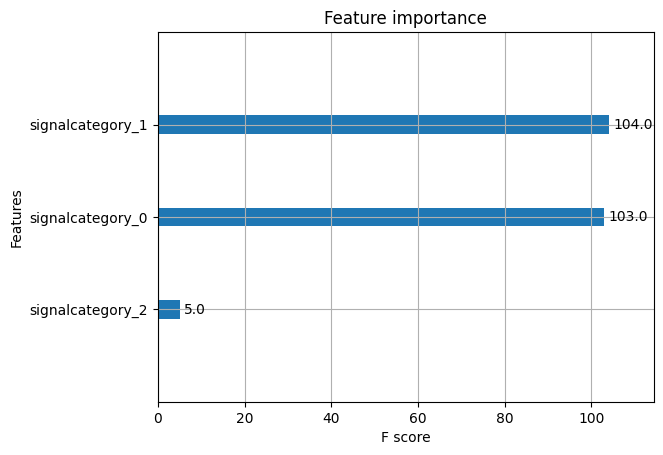

['signalcategory_0', 'signalcategory_1', 'signalcategory_2']


In [43]:
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
#pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#plot feature importance
plot_importance(model)
pyplot.show()
print(model.get_booster().feature_names)